<a href="https://colab.research.google.com/github/ald-ahmed/SurfCrowd/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SurfCrowd - A Realtime Surfer Detection Model


The following work showcases a yolo-based model that has been trained on surfing live cams. The output shows bounding boxes around surfers, enabling tracking and/or counting abilities in realtime. Powered by [Surfline](https://www.surfline.com) and created by [A. Dulaimy](https://www.linkedin.com/in/jordan-d-b4b0a4191/)


 <br /> 
*To run the  entire notebook, open in Colab then go to Runtime -> Run all*
 <br /> 
 <br /> 

---
<br/> 

Example output on Upper Trestles live cam ([source](https://www.surfline.com/surf-report/upper-trestles/5842041f4e65fad6a7708887))

 <br /> 

<div>
<img src="https://storage.googleapis.com/ahmed.software/projects/surfcrowd2-min.gif" width="640"/>
</div>

<br/> 
<br/> 

Performance metrics on a small dataset after 300 epochs of training (~1000 images with 15-20 surfers)

<br/> 

<div>
<img src="http://ahmed.software/projects/crowd%20surf%20performance.png" width="640"/>
</div>




#Install Dependencies

*Choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU*

In [2]:
!git clone https://github.com/ald-ahmed/SurfCrowd  # clone repo
!pip install -r SurfCrowd/requirements.txt

%cd SurfCrowd

import torch
from IPython.display import Image, clear_output 

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


# Model Configuration and Architecture

Here is a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

*This is here for informational purposes only. You do not need to edit these cells.*

In [3]:
%cd /content/

num_classes = "1"

##write custom model .yaml
#you can configure this based on other YOLOv5 models in the models directory
with open('SurfCrowd/models/custom_yolov5s.yaml', 'w') as f:
  # parameters
  f.write('nc: ' + num_classes + '\n')
  #f.write('nc: ' + str(len(class_labels)) + '\n')
  f.write('depth_multiple: 0.33'  + '\n') # model depth multiple
  f.write('width_multiple: 0.50'  + '\n')  # layer channel multiple
  f.write('\n')
  f.write('anchors:' + '\n')
  f.write('  - [10,13, 16,30, 33,23] ' + '\n')
  f.write('  - [30,61, 62,45, 59,119]' + '\n')
  f.write('  - [116,90, 156,198, 373,326] ' + '\n')
  f.write('\n')

  f.write('backbone:' + '\n')
  f.write('  [[-1, 1, Focus, [64, 3]],' + '\n')
  f.write('   [-1, 1, Conv, [128, 3, 2]],' + '\n')
  f.write('   [-1, 3, Bottleneck, [128]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 3, 2]],' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [256]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 3, 2]], ' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [512]],' + '\n')
  f.write('   [-1, 1, Conv, [1024, 3, 2]],' + '\n')
  f.write('   [-1, 1, SPP, [1024, [5, 9, 13]]],' + '\n')
  f.write('   [-1, 6, BottleneckCSP, [1024]],' + '\n')
  f.write('  ]' + '\n')
  f.write('\n')

  f.write('head:'  + '\n')
  f.write('  [[-1, 3, BottleneckCSP, [1024, False]],'  + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  
  f.write('   [[-1, 6], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [512, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  f.write('   [[-1, 4], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [256, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('\n' )
  f.write('   [[], 1, Detect, [nc, anchors]],' + '\n')
  f.write('  ]' + '\n')

print('custom model config written!')

/content
custom model config written!


# Predict

The following will load the pretrained weigths into the model and  generate an output for each frame in the input video. Each frame takes around 0.020s to process, which translates to 50 fps!


In [ ]:
%cd /content/SurfCrowd/
!rm -rf /inference/output

# predict using the pretrained weights. Note the image size, confidence, and source parameters  
!python detect.py --weights weights/last_yolov5s_results.pt --img 1920 --save-txt --conf 0.4 --source data/test/video/1.mp4

count    269.000000
mean      27.925651
std        1.243660
min       24.000000
25%       27.000000
50%       28.000000
75%       29.000000
max       33.000000
dtype: float64


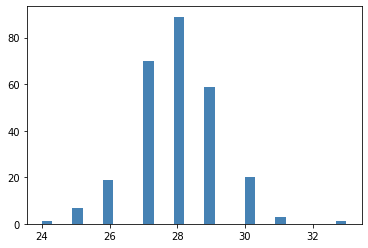

In [5]:
import glob
import pandas as pd 
import matplotlib.pyplot as plt

inferedData = []
for txtName in glob.glob('/content/SurfCrowd/inference/output/*.txt'):
    num_lines = sum(1 for line in open(txtName))  
    inferedData.append(num_lines)

stats = pd.Series(inferedData).describe()
print(stats)
plt.hist(inferedData, bins=30, alpha=1, histtype='stepfilled', color='steelblue');

# # uncomment this if images were inputed 
# from IPython.display import Image, display
# for imageName in glob.glob('/content/SurfCrowd/inference/output/*.jpg'):
#     display(Image(filename=imageName))
#     print("\n")

Run this cell to show the generated video if one was used in the input. This will take a bit given the need to convert/compress the generated video.

In [6]:
from IPython.display import HTML
from base64 import b64encode
import os

# compress the outputed video to display it
save_path = "/content/SurfCrowd/inference/output/1.mp4"
compressed_path = "/content/compressed1.mp4"
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show the outputed video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=640 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)